In [1]:
pip install minatar

In [2]:
pip install ale-py

In [3]:
pip install gymnasium

In [4]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [5]:
from gymnasium import spaces
from minatar import Environment

class MinAtarEnv(gym.Env):
    def __init__(self, game_name):
        super().__init__()
        # Initialize the MinAtar environment
        self.minatar_env = Environment(env_name=game_name)

        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=self.minatar_env.state_shape(),
            dtype=float
        )
        self.action_space = spaces.Discrete(self.minatar_env.num_actions())

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.minatar_env.reset()
        # Return the initial state and an empty info dict
        return self.minatar_env.state(), {}

    def step(self, action):
        reward, done = self.minatar_env.act(action)
        return self.minatar_env.state(), reward, done, done, {}

    def render(self, mode="human"):
        arr=(self.minatar_env.state()*np.arange(1,7)).max(axis=2)
        num_to_char = {
          0: ' ',
          1: '\u2569',
          2: '\u2ADA',
          3: '\u2ADA',
          4: '\u2ADA',
          5: '|',
          6: ':'
        }
        char_grid = np.vectorize(num_to_char.get)(arr)
        padded_rows = []
        for row in char_grid:
          padded_row = ''.join(char for char in row)
          padded_rows.append(padded_row)
        final_grid = '\n'.join(padded_rows)
        print(final_grid)

    def close(self):
        # Clean up resources if needed
        pass


# Instantiate the custom MinAtar space_invaders environment
env = MinAtarEnv("space_invaders")

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [7]:
class DQNCNN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQNCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        conv_out_size = self._get_conv_output(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def _get_conv_output(self, shape):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, *shape))
            return int(np.prod(o.size()))

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return torch.stack(states), actions, torch.tensor(rewards), torch.stack(next_states), torch.tensor(dones)

In [9]:
input_shape = (env.observation_space.shape[2], env.observation_space.shape[0], env.observation_space.shape[1])
n_actions = env.action_space.n

print(f"obs space shape: {env.observation_space.shape}")

q_network = DQNCNN(input_shape, n_actions).to(device)
target_network = DQNCNN(input_shape, n_actions).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

obs space shape: (10, 10, 6)


In [ ]:
#set hyperparams -- play with any of these!
gamma=0.99
buffer_size=8000
batch_size=128
num_episodes=20000
C = 500
num_steps_report = 1000

RB=ReplayBuffer(buffer_size) #initialize Replay Buffer
epsilon=1 #initialize epsilon

reward_list = []
global_step = 0

for e in range(num_episodes):
  new_obs,info=env.reset()
  new_obs = torch.tensor(new_obs, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)

  done=False
  truncated=False
  total_loss = 0
  loss_count = 0
  steps_in_episode = 0
  episode_reward = 0

  while not done and not truncated: #Loop for one episode
    obs=new_obs

    #choose action
    t=np.random.random()
    if t>epsilon:
      with torch.no_grad():
        action=torch.argmax(q_network(obs)).item() #exploitation
    else:
      action= env.action_space.sample()

    #take a step:
    new_obs,reward, done, truncated, info=env.step(action)

    new_obs = torch.tensor(new_obs, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)

    RB.push(obs,action,reward,new_obs,done)
    global_step+=1
    steps_in_episode+=1
    episode_reward+=reward
    reward_list.append(episode_reward)

    if len(RB.buffer)>=batch_size:
      states, actions, rewards, next_states, dones=RB.sample(batch_size)
      states = states.squeeze(1).to(device)
      next_states = next_states.squeeze(1).to(device)

      #current q-value
      actions = torch.tensor(actions, dtype=torch.long).to(device)
      rewards = rewards.to(device)
      dones = dones.to(device)

      current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

      #compute target q-value
      with torch.no_grad():
        max_next_q = target_network(next_states).max(1)[0]
        target_q = rewards + (1 - dones.float()) * gamma * max_next_q

      #compute loss
      loss = loss_fn(current_q, target_q)
      total_loss += loss.item()
      loss_count += 1

      #Q-network update rule:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if global_step % num_steps_report == 0:
        print(f"step {global_step}: episode {e}, steps in episode {steps_in_episode}, epsilon: {epsilon}, total reward in ep: {episode_reward}")

  #reduce episilon if its not too low:
  epsilon = max(0.01, 0.5 * (1 - e / num_episodes) + 0.5 * epsilon * 0.997)

  #update target network perodically
  if e % C == 0:
      target_network.load_state_dict(q_network.state_dict())
      print(f"episode {e}: updated target network")

  if e % 1000 == 0 and e > 0:
    torch.save({
        'episode': e,
        'model_state_dict': q_network.state_dict(),
        'target_state_dict': target_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon,
    }, f"checkpoint_episode_{e}.pth")
    print(f"saved checkpoint at episode {e}")

  # #periodic reporting:
  # if e>0 and e%100==0:
  #   print(f'episode: {e}, steps: {steps}, epsilon: {epsilon},win: {reward==10}')


episode 0: updated target network
step 1000: episode 20, steps in episode 43, epsilon: 0.9961113693937569, total reward in ep: 3
step 2000: episode 39, steps in episode 31, epsilon: 0.9951642082724952, total reward in ep: 1
step 3000: episode 65, steps in episode 19, epsilon: 0.9938680966074857, total reward in ep: 3
step 4000: episode 88, steps in episode 29, epsilon: 0.9927215362884427, total reward in ep: 3
step 5000: episode 114, steps in episode 9, epsilon: 0.9914254246234377, total reward in ep: 1
step 6000: episode 142, steps in episode 43, epsilon: 0.9900296120611247, total reward in ep: 5
step 7000: episode 169, steps in episode 30, epsilon: 0.9886836499474657, total reward in ep: 1
step 8000: episode 187, steps in episode 97, epsilon: 0.987786341871693, total reward in ep: 9
step 9000: episode 204, steps in episode 7, epsilon: 0.9869388842445743, total reward in ep: 0
step 10000: episode 221, steps in episode 16, epsilon: 0.9860914266174556, total reward in ep: 0
step 11000: 

In [ ]:
obs, info = env.reset()
done = False
truncated = False

while not done and not truncated:
    env.render()
    obs=torch.tensor(obs,dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)
    with torch.no_grad():
        action = torch.argmax(q_network(obs)).item()
    obs, reward, done, truncated, info = env.step(action)
    sleep(1)
    clear_output(wait=True)

env.render()
env.close()

          
          
          
 ⫚⫚       
⫚⫚⫚  |    
⫚⫚⫚       
⫚⫚        
          
          
  :       


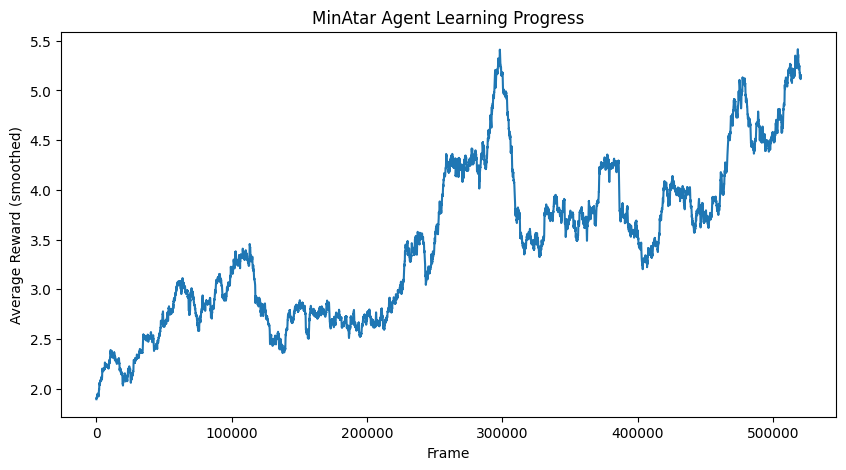

In [ ]:
plt.figure(figsize=(10,5))
window_size = 15000
smoothed_rewards = np.convolve(reward_list, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_rewards)
plt.xlabel('Frame')
plt.ylabel('Average Reward (smoothed)')
plt.title('MinAtar Agent Learning Progress')
plt.show()